# Homework №4
This homework will be dedicated to the Text-to-Speech(**TTS**), specifically the acoustic models.

# Data

    In this homework we will use only LJSpeech https://keithito.com/LJ-Speech-Dataset/.
    Use text from `Normalized Transcription` field in transcripts.csv.
    
    Use the following `featurizer` (his configuration is +- standard for this task):

In [1]:
!pip uninstall -y torch
!pip uninstall -y torchaudio

Found existing installation: torch 1.6.0
Uninstalling torch-1.6.0:
  Successfully uninstalled torch-1.6.0
Found existing installation: torchaudio 0.6.0a0+f17ae39
Uninstalling torchaudio-0.6.0a0+f17ae39:
  Successfully uninstalled torchaudio-0.6.0a0+f17ae39


In [2]:
!pip install torch==1.7.0 torchaudio
!pip install easydict
!pip install wandb

     |████████████████████████████████| 776.7 MB 3.4 kB/s 
     |████████████████████████████████| 7.6 MB 1.6 MB/s 
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

fastai 2.0.19 requires torch<1.7,>=1.6, but you'll have torch 1.7.0 which is incompatible.
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6349 sha256=454f3e4a2eaa808f338cc00de7035c0853248ca1c8c09c9a4f11f09b85a0b02e
  Stored in directory: /root/.cache/pip/wheels/88/96/68/c2be18e7406804be2e593e1c37845f2dd20ac2ce1381ce40b0
Successfully built easydict


In [3]:
!wandb login ee9416edde558c322450d0ec80266d2c0db81f45

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
'''
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2 
!tar -xjf ./LJSpeech-1.1.tar.bz2
'''

'\n!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2 \n!tar -xjf ./LJSpeech-1.1.tar.bz2\n'

In [5]:
import wandb
from IPython import display
from dataclasses import dataclass

import torch
from torch import nn
import numpy as np
import random

import torchaudio

import librosa
from matplotlib import pyplot as plt


@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0
    device: 'Torch devcie' = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()
        
        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        ).to(config.device)

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))
    

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """
        
        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [6]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, checkpoint, patience=7, verbose=False, delta=0, min_loss=np.inf):
        """
        :param
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None if min_loss == np.inf else  -min_loss
        self.early_stop = False
        self.val_loss_min = min_loss
        self.delta = delta
        self.checkpoint = checkpoint

    def __call__(self, val_loss, model, optimizer, scheduler):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, scheduler):
        """
        Saves model when validation loss decrease.
        """
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': val_loss
            }, self.checkpoint)

        self.val_loss_min = val_loss

In [7]:
featurizer = MelSpectrogram(MelSpectrogramConfig())

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
wav, sr = torchaudio.load('../input/dlaht4dataset/LJSpeech-1.1/wavs/LJ001-0001.wav')
mels = featurizer(wav.to(device))

/opt/conda/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/opt/conda/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


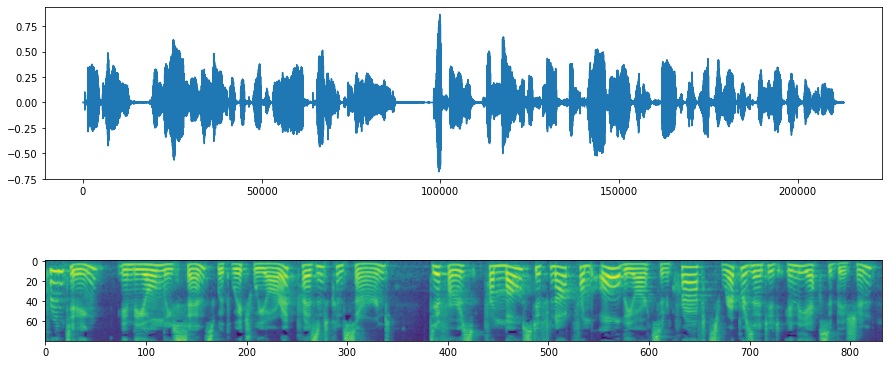

In [9]:
_, axes = plt.subplots(2, 1, figsize=(15, 7))
axes[0].plot(wav.cpu().squeeze())
axes[1].imshow(mels.cpu().squeeze())

plt.show()

### We will use pretrained Vocoder from Nvidia

In [10]:
'''
!git clone https://github.com/NVIDIA/waveglow.git
!pip install googledrivedownloader
'''

'\n!git clone https://github.com/NVIDIA/waveglow.git\n!pip install googledrivedownloader\n'

    Download pretrained model from https://github.com/NVIDIA/waveglow

In [11]:
'''
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(
    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',
    dest_path='./waveglow_256channels_universal_v5.pt'
)
'''

"\nfrom google_drive_downloader import GoogleDriveDownloader as gdd\ngdd.download_file_from_google_drive(\n    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',\n    dest_path='./waveglow_256channels_universal_v5.pt'\n)\n"

### Use the following Vocoder for final quality validation

In [12]:
import sys
sys.path.append('../input/dlaht4dataset/waveglow')

import warnings
warnings.filterwarnings('ignore')


class Vocoder(nn.Module):
    
    def __init__(self):
        super(Vocoder, self).__init__()
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = torch.load('../input/dlaht4dataset/waveglow_256channels_universal_v5.pt', map_location=device)['model']
        self.net = model.remove_weightnorm(model)
    
    @torch.no_grad()
    def inference(self, spect: torch.Tensor):
        spect = self.net.upsample(spect)
        
        # trim the conv artifacts
        time_cutoff = self.net.upsample.kernel_size[0] - self.net.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]
        
        spect = spect.unfold(2, self.net.n_group, self.net.n_group) \
            .permute(0, 2, 1, 3) \
            .contiguous() \
            .flatten(start_dim=2) \
            .transpose(-1, -2)
        
        # generate prior
        audio = torch.randn(spect.size(0), self.net.n_remaining_channels, spect.size(-1)) \
            .to(spect.device)
        
        for k in reversed(range(self.net.n_flows)):
            n_half = int(audio.size(1) / 2)
            audio_0 = audio[:, :n_half, :]
            audio_1 = audio[:, n_half:, :]

            output = self.net.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b) / torch.exp(s)
            audio = torch.cat([audio_0, audio_1], 1)

            audio = self.net.convinv[k](audio, reverse=True)

            if k % self.net.n_early_every == 0 and k > 0:
                z = torch.randn(spect.size(0), self.net.n_early_size, spect.size(2)).to(device)
                audio = torch.cat((z, audio), 1)

        audio = audio.permute(0, 2, 1) \
            .contiguous() \
            .view(audio.size(0), -1)
        
        return audio

In [13]:
vocoder = Vocoder().to(device)
vocoder = vocoder.eval()

### Test pretrained vocoder

In [14]:
wav, sr = torchaudio.load('../input/dlaht4dataset/LJSpeech-1.1/wavs/LJ001-0001.wav')
mels = featurizer(wav.to(device))

print(mels.shape)
reconstructed_wav = vocoder.inference(mels)

torch.Size([1, 80, 832])


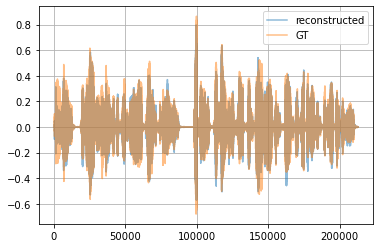

In [15]:
plt.plot(reconstructed_wav.squeeze().cpu(), label='reconstructed', alpha=.5)
plt.plot(wav.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [16]:
display.Audio(reconstructed_wav.cpu().squeeze(), rate=22050)

In [17]:
display.Audio(wav.cpu().squeeze(), rate=22050)

# Model

    1) You need to implement Tacotron 2: https://www.dropbox.com/s/il9ai3ihh3nbcoo/Tacotron2.pdf?dl=0
    
    2) For fast convergence, implement Guided Attention: https://www.dropbox.com/s/tiibpqcdb1eieg4/GaidedAttention.pdf?dl=0
       It will increase convergence by several times!
    
    3) (Bonus) Implement Monotonic Attention: https://www.dropbox.com/s/6deupekgd4ep0kg/MonotonicAttention.pdf?dl=0
    
    4) (Bonus) Implement Tacotron with GST.
        For testing GST find 5-10 audio references with questioning tone and generate audio with this references.
        
    5) (PAY ATTENTION) Tacotron has RNNs, so don't forget about length masks.

# Code

    1) In this homework you are allowed to use pytorch-lighting.

    2) Try to write code more structurally and cleanly!

    3) Good logging of experiments save your nerves and time, so we ask you to use W&B.
       Log loss, generated and real melspectrograms (in pair, i.e. real melspec and generated from correspond text). 
       Do not remove the logs until we have checked your work and given you a grade!

    4) (Bonus) We also ask you to organize your code in github repo with Docker and setup.py. You can use my template https://github.com/markovka17/dl-start-pack.

    5) Your work must be reproducable, so fix seed, save the weights of model, and etc.

    6) In the end of your work write inference utils. Anyone should be able to take your weight, load it into the model and run it on some melspec.

In [18]:
!pip install easydict

In [19]:
import torch
import torch.nn.functional as F
from easydict import EasyDict as edict
from torch.nn.init import calculate_gain
import pandas as pd
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
import string
import os
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm
from itertools import islice

In [20]:
def make_vocab(n_transcriptions):
    vocab = set()
    for sent in n_transcriptions:
        for c in sent:
            vocab.add(c)
    return vocab


class LJSpeech(Dataset):

    def __init__(self, root, lblpath):
        super(LJSpeech, self).__init__()
        self.root = root
        meta = pd.read_csv(os.path.join(root, lblpath), sep='|', header=None)
        meta.columns = ['ID', 'Transcription', 'Normalized Transcription']
        meta.dropna(inplace=True)
        self.vocab = make_vocab(meta['Normalized Transcription'].values)

        self.stoi = {k:v+1 for v, k in enumerate(self.vocab)}
        self.stoi['<pad>'] = 0
        self.itos = {k+1:v for k, v in enumerate(self.vocab)}
        self.itos[0] = '<pad>'
        meta['Path'] = 'wavs/' + meta['ID'] + '.wav'
        meta['Tokens'] = meta['Normalized Transcription'].apply(
            lambda string: [self.stoi[s] for s in string])
        self.files = meta['Path'].values
        self.data = meta['Tokens'].values
        self.lens = meta['Normalized Transcription'].str.len().values
        self.hop_len = 256
        
    
    def __getitem__(self, idx):
        filepath = os.path.join(self.root, self.files[idx])
        wav, sr = torchaudio.load(filepath)
        wav = wav.squeeze(0)
        text = self.data[idx]
        return torch.LongTensor(text), len(text), wav, (len(wav) // self.hop_len + 1)
        
  
    def __len__(self):
        return len(self.files)


def collate_fn(batch):
    X, X_lens, y, y_lens = zip(*batch)
    X = pad_sequence(X, batch_first=True)
    y = pad_sequence(y, batch_first=True)
    return X, torch.Tensor(X_lens).type(torch.int32), y, torch.LongTensor(y_lens).unsqueeze(-1)


def make_loader(dataset, bs, train=True):
    weights = torch.ones(len(dataset))
    if train:
        idx = dataset.indices
        weights /= (dataset.dataset.lens[idx])
    sampler = WeightedRandomSampler(weights, num_samples=len(dataset))
    loader = DataLoader(dataset, batch_size=bs, num_workers=1,
                              pin_memory=True, collate_fn=collate_fn,
                              sampler=sampler)
    return loader

In [21]:
config = {
    'n_mels': 80,
    'emb_dim': 512,
    'dropout_p': 0.5,
    'encoder_n_convs': 3,
    'encoder_channels': 512,  # always equals to emb_dim
    'encoder_kernel_size': 5,
    'vocab_size': 0,
    'encoder_hidden_dim': 256,
    'attn_dim': 128,
    'attn_n_filters': 32,
    'attn_kernel_size': 31,
    'prenet_dim': 256,
    'postnet_n_convs': 5,
    'postnet_channels': 512,
    'postnet_kernel_size': 5,
    'attn_lstm_dim': 1024,
    'decoder_lstm_dim': 1024,
    'decoder_dropout_p': 0.1,
    'stop_thr': 0.5,
    'max_len': 1000,
    'guided_attn_g': 0.2,
    'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    'batch_size': 32,
    'epochs': 20
}

config = edict(config)

In [22]:
dataset = LJSpeech('../input/dlaht4dataset/LJSpeech-1.1', 'metadata.csv')
full_ds_size = len(dataset)
train_size, test_size = int(0.9 * 0.8 * full_ds_size), int(0.1 * full_ds_size) 
val_size = full_ds_size - train_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, lengths=[train_size, val_size, test_size])
bs = config.batch_size
config.vocab_size = len(dataset.vocab) + 1  # 1 for <pad>
train_loader = make_loader(train_ds, bs)
val_loader = make_loader(val_ds, bs, False)
test_loader = make_loader(test_ds, 1, False)

In [23]:
class ConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                activation=nn.Identity(), activation_name='linear', dropout_p=0.0):
        super(ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, 
                              padding=kernel_size // 2),
                              nn.BatchNorm1d(out_channels),
                              activation,
                              nn.Dropout(p=dropout_p)
                              )

        torch.nn.init.xavier_uniform_(self.conv[0].weight,
              gain=calculate_gain(activation_name))
        
    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):

    def __init__(self, config):
        super(Encoder, self).__init__()
        conv_list = [ConvLayer(config.encoder_channels, config.encoder_channels,
            config.encoder_kernel_size, nn.ReLU(), 'relu', config.dropout_p) 
            for _ in range(config.encoder_n_convs)]
        self.convs = nn.ModuleList(conv_list)
        self.lstm = nn.LSTM(config.encoder_channels, config.encoder_hidden_dim,
                            bidirectional=True)

    def forward(self, x, input_lens):
        for conv in self.convs:
            x = conv(x)
        x = x.transpose(1, 2)
        x = nn.utils.rnn.pack_padded_sequence(x, input_lens, batch_first=True, 
                                              enforce_sorted=False)
        x, _ = self.lstm(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        return x

In [24]:
class LocationBlock(nn.Module):

    def __init__(self, config):
        super(LocationBlock, self).__init__()
        self.conv = nn.Conv1d(2, config.attn_n_filters,
            kernel_size=config.attn_kernel_size,
            padding=config.attn_kernel_size // 2, bias=False)
        
        self.proj = nn.Linear(config.attn_n_filters, config.attn_dim, 
                                    bias=False)
        
        torch.nn.init.xavier_uniform_(self.conv.weight)
        torch.nn.init.xavier_uniform_(self.proj.weight, gain=calculate_gain('tanh'))
    
    def forward(self, attention_weights):
        output = self.conv(attention_weights).transpose(1, 2)
        output = self.proj(output)
        return output


class LocationSensitiveAttention(nn.Module):

    def __init__(self, config):
        super(LocationSensitiveAttention, self).__init__()
        self.query_layer = nn.Linear(config.attn_lstm_dim, config.attn_dim, bias=False)
        self.v = nn.Linear(config.attn_dim, 1, bias=False)
        self.location_layer = LocationBlock(config)
        self.score_mask_value = -float("inf")
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

        torch.nn.init.xavier_uniform_(self.query_layer.weight, gain=calculate_gain('tanh'))
        torch.nn.init.xavier_uniform_(self.v.weight)

        
    def get_energies(self, query, processed_memory, attn_weights):
        processed_query = self.query_layer(query.unsqueeze(1))
        processed_attn_weights = self.location_layer(attn_weights)
        
        energies = self.v(self.tanh(processed_query + 
                                    processed_attn_weights + processed_memory))
        energies = energies.squeeze(2)
        return energies
    
    def forward(self, decoder_q, memory, processed_memory, attn_weights, mask):
        energies = self.get_energies(decoder_q, processed_memory, attn_weights)

        energies = energies.masked_fill(mask, self.score_mask_value)

        attn_weights = self.softmax(energies)
        attn_context = torch.bmm(attn_weights.unsqueeze(1), memory)
        attn_context = attn_context.squeeze(1)
        return attn_context, attn_weights

In [25]:
class PreNet(nn.Module):

    def __init__(self, config):
        super(PreNet, self).__init__()
        self.config = config
        self.layers = nn.ModuleList([nn.Sequential(
            nn.Linear(config.n_mels, config.prenet_dim),
            nn.ReLU())] + 
            [nn.Sequential(
            nn.Linear(config.prenet_dim, config.prenet_dim),
            nn.ReLU())])

        for layer in self.layers:
               torch.nn.init.xavier_uniform_(layer[0].weight)       

    def forward(self, x):
        # dropout always on
        for layer in self.layers:
            x = F.dropout(layer(x), p=self.config.dropout_p)
        return x


class PostNet(nn.Module):

    def __init__(self, config):
        super(PostNet, self).__init__()
        conv_list = [ConvLayer(config.n_mels, config.postnet_channels,
                      config.postnet_kernel_size, nn.Tanh(), 'tanh', config.dropout_p)] + \
          [ConvLayer(config.postnet_channels, config.postnet_channels,
           config.postnet_kernel_size, nn.Tanh(), 'tanh', config.dropout_p)
           for _ in range(config.postnet_n_convs - 2)] + \
          [ConvLayer(config.postnet_channels, config.n_mels,
                      config.postnet_kernel_size, dropout_p=config.dropout_p)]
        self.convs = nn.ModuleList(conv_list)        

    def forward(self, x):
        x = x.transpose(1, 2)
        for conv in self.convs:
            x = conv(x) 
        return x.transpose(1, 2)


def get_mask_from_lens(lens, config):
    max_len = torch.max(lens).item()
    ids = torch.arange(0, max_len)
    mask = (ids < lens.unsqueeze(1)).bool()
    return mask.to(config.device)


@dataclass
class AttentionInfo:
    attn_weights: 'Tensor[float]'
    attn_weights_cum: 'Tensor[float]'
    attn_context: 'Tensor[float]'


@dataclass
class LSTMStates:
    hidden: 'Tensor[float]'
    cell: 'Tensor[float]'


class Decoder(nn.Module):

    def __init__(self, config):
        super(Decoder, self).__init__()
        lstm_input_dim = 2 * config.encoder_hidden_dim + config.prenet_dim
        self.config = config
        self.attn_lstm = nn.LSTMCell(lstm_input_dim, config.attn_lstm_dim)
        self.attn_dropout = nn.Dropout(config.decoder_dropout_p)
        self.decoder_lstm = nn.LSTMCell(config.attn_lstm_dim + 
                                        2 * config.encoder_hidden_dim,
                                        config.decoder_lstm_dim)
        self.decoder_dropout = nn.Dropout(config.decoder_dropout_p)
        self.attn_layer = LocationSensitiveAttention(config)
        self.prenet = PreNet(config)
        self.postnet = PostNet(config)
        linear_input_dim = config.decoder_lstm_dim + 2 * config.encoder_hidden_dim
        self.stop_prob = nn.Sequential(
            nn.Linear(linear_input_dim, 1),
            nn.Sigmoid())
        self.mel_proj = nn.Linear(linear_input_dim, config.n_mels)
        self.memory_layer = nn.Linear(2 * config.encoder_hidden_dim, config.attn_dim, bias=False) # memory to attention_dim 
        self.pad_value = -11.5129251

        torch.nn.init.xavier_uniform_(self.stop_prob[0].weight, gain=calculate_gain('sigmoid'))
        torch.nn.init.xavier_uniform_(self.memory_layer.weight, gain=calculate_gain('tanh'))
        torch.nn.init.xavier_uniform_(self.mel_proj.weight)


    def init_weights_and_hiddens(self, memory):
        #init from tacotron2
        b_sz, seq_len, encoder_dim = memory.shape

        device = self.config.device
        attn_hidden = torch.zeros((b_sz, self.config.attn_lstm_dim), device=device)
        attn_cell = torch.zeros((b_sz, self.config.attn_lstm_dim), device=device)
        self.attn_states = LSTMStates(attn_hidden, attn_cell)

        decoder_hidden = torch.zeros((b_sz, self.config.decoder_lstm_dim), device=device)
        decoder_cell = torch.zeros((b_sz, self.config.decoder_lstm_dim), device=device)
        self.decoder_states = LSTMStates(decoder_hidden, decoder_cell)

        attn_weights = torch.zeros((b_sz, seq_len), device=device)
        attn_weights_cum = torch.zeros((b_sz, seq_len), device=device)
        attn_context = torch.zeros((b_sz, encoder_dim), device=device)
        self.attn_info = AttentionInfo(attn_weights, attn_weights_cum, attn_context)
        

    def decode(self, decoder_input, memory, attn_memory, mask):
        cell_input = torch.cat((decoder_input, self.attn_info.attn_context), -1)
        attn_hidden, self.attn_states.cell =  self.attn_lstm(cell_input, 
                                               (self.attn_states.hidden, self.attn_states.cell))
        self.attn_states.hidden = self.attn_dropout(attn_hidden)

        attn_weights_cat = torch.cat((self.attn_info.attn_weights.unsqueeze(1),
                                      self.attn_info.attn_weights_cum.unsqueeze(1)), dim=1)
        
        attn_context, attn_weights = self.attn_layer(
            self.attn_states.hidden, memory, attn_memory, attn_weights_cat, mask)
        self.attn_info.attn_context, self.attn_info.attn_weights = attn_context, attn_weights
        self.attn_info.attn_weights_cum += attn_weights

        decoder_input = torch.cat((self.attn_states.hidden, attn_context), -1)
        decoder_hidden, self.decoder_states.cell = self.decoder_lstm(
            decoder_input, (self.decoder_states.hidden, self.decoder_states.cell))
        self.decoder_states.hidden = self.decoder_dropout(decoder_hidden)

        pred = torch.cat((self.decoder_states.hidden, attn_context), dim=1)
        decoder_output = self.mel_proj(pred).unsqueeze(1)
        stop_prob = self.stop_prob(pred)
        return decoder_output, stop_prob, attn_weights.unsqueeze(-1)


    def forward(self, memory, memory_lens, decoder_inputs, teacher_forcing):
        b_sz, seq_len, _ = memory.shape
        
        first_input = torch.ones_like(decoder_inputs[:,0,:]).unsqueeze(1) * self.pad_value # decoder inputs: (b_sz, seq_len, n_mels)
        decoder_inputs = torch.cat((first_input, decoder_inputs), dim=1)
        decoder_inputs = self.prenet(decoder_inputs).transpose(0, 1)  # (seq_len + 1, b_sz, n_mels)

        self.init_weights_and_hiddens(memory)
        attn_memory = self.memory_layer(memory)

        mel_pred = torch.Tensor([]).to(config.device)
        stop_probs = torch.Tensor([]).to(config.device)
        attn_mtx = torch.Tensor([]).to(config.device)
        mask = ~get_mask_from_lens(memory_lens, config)
        
        mel_output = (torch.ones((b_sz, self.config.n_mels)) * self.pad_value).to(device)
        
        for decoder_input in decoder_inputs:
            if torch.rand((1)).item() >= teacher_forcing:
                decoder_input = self.prenet(mel_output).squeeze(1)
            mel_output, stop_prob, attn_weights = self.decode(decoder_input,  # (b_sz, prenet_dim)
                                                memory, attn_memory, mask)
            mel_pred = torch.cat((mel_pred, mel_output), dim=1) # (b_sz, i, n_mels)
            stop_probs = torch.cat((stop_probs, stop_prob), dim=1) 
            attn_mtx = torch.cat((attn_mtx, attn_weights), dim=-1)
        
        mel_pred = mel_pred[:, :-1, :]
        mel_res = self.postnet(mel_pred)
        return mel_pred, mel_pred + mel_res, stop_probs, attn_mtx    


    def inference(self, memory, memory_lens):
        device = self.config.device
        b_sz, seq_len, _ = memory.shape
        decoder_input = (torch.ones((b_sz, self.config.n_mels)) * self.pad_value).to(device)

        self.init_weights_and_hiddens(memory)
        attn_memory = self.memory_layer(memory)
        mask = ~get_mask_from_lens(memory_lens, config)

        mel_pred = torch.Tensor([]).to(device)
        steps = 0
        while True:
            decoder_input = self.prenet(decoder_input)
            mel_output, stop_prob, attn_weights = self.decode(decoder_input, memory, attn_memory, mask)
            mel_pred = torch.cat((mel_pred, mel_output), dim=1) # (b_sz, i, n_mels)
            steps += 1
            if stop_prob.item() > self.config.stop_thr or steps > config.max_len:
                break
            decoder_input = mel_output.squeeze(1)
        mel_res = self.postnet(mel_pred)
        return mel_pred + mel_res, stop_prob


In [26]:
class Tacotron2(nn.Module):

    def __init__(self, config):
        super(Tacotron2, self).__init__()
        self.embedding = nn.Embedding(
            config.vocab_size, config.emb_dim)
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

        #initialization from the paper
        std = np.sqrt(2.0 / (config.vocab_size + config.emb_dim))
        val = np.sqrt(3.0) * std 
        self.embedding.weight.data.uniform_(-val, val)

    def forward(self, seq, seq_lens, mel, teacher_forcing):
        embedded = self.embedding(seq).transpose(1, 2)
        memory = self.encoder(embedded, seq_lens)
        mel_pre, mel_post, stop_pred, attn_mtx = self.decoder(memory, seq_lens, mel, teacher_forcing)
        return mel_pre, mel_post, stop_pred, attn_mtx

    def inference(self, seq, seq_lens):
        embedded = self.embedding(seq).transpose(1, 2)
        memory = self.encoder(embedded, seq_lens)
        mel_post, stop_pred = self.decoder.inference(memory, seq_lens)
        return mel_post

In [27]:
def make_w(g, N, T):
    n = torch.true_divide(torch.arange(N), N).unsqueeze(1)
    t = torch.true_divide(torch.arange(T), T).unsqueeze(0)
    log_w = torch.true_divide((-n**2 + 2 * n * t - t**2), (2 * g**2))
    w = 1 - torch.exp(log_w)
    return w.to(config.device)

def make_mask(max_len, mel_lens, batch_size, device):
    idx = torch.arange(end=max_len).unsqueeze(0).repeat(batch_size, 1).to(device)
    mask = idx <= mel_lens
    return mask

class StopLoss(nn.Module):

    def __init__(self):
        super(StopLoss, self).__init__()
        self.criterion = nn.BCELoss(reduction='none')

    def forward(self, stop_probs, mel_lens):
        batch_size, max_len = stop_probs.shape
        device = stop_probs.device
        labels = torch.zeros_like(stop_probs)
        labels.scatter_(1, mel_lens, 1.0)
        mask = make_mask(max_len, mel_lens, batch_size, device)
        loss = (self.criterion(stop_probs, labels) * mask).mean(dim=0).sum()
        return loss


class GuidedAttentionLoss(nn.Module):

    def __init__(self):
        super(GuidedAttentionLoss, self).__init__()

    def forward(self, A, g, mel_lens, seq_lens):
        W = torch.zeros_like(A)
        for i, sizes in enumerate(zip(mel_lens, seq_lens)):
            t, n = sizes
            w = make_w(g, n.item(), t.item())
            W[i,: n,: t] = w
        loss = (W * A).mean(dim=0).sum()
        return loss

class MaskedMSELoss(nn.Module):

    def __init__(self):
        super(MaskedMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='none')

    def forward(self, mel_pred, mel_target, mel_lens):
        batch_size, max_len, n_mels = mel_pred.shape
        device = mel_pred.device
        mask = make_mask(max_len, mel_lens, batch_size, device)
        mask = mask.unsqueeze(-1).repeat(1, 1, n_mels)
        loss = (self.criterion(mel_pred, mel_target) * mask).mean()
        return loss

In [28]:
import matplotlib.pyplot as plt
device = config.device
emb = nn.Embedding(config.vocab_size, config.emb_dim).to(device)
relu = nn.ReLU().to(device)
conv =  ConvLayer(config.encoder_channels, config.encoder_channels,
            config.encoder_kernel_size, relu, 'relu', config.dropout_p).to(device)
encoder = Encoder(config).to(device)
decoder = Decoder(config).to(device)
taco = Tacotron2(config).to(device)

stop_loss = StopLoss()

i = 0
for el in train_loader:
    seq, seq_len, audio, mel_len = el
    if seq.shape[-1] > 20:
        continue
    print('seq shape:', seq.shape)
    seq, mel_len = seq.to(device), mel_len.to(device)
    embed = emb(seq).transpose(1, 2).to(device)
    print('embed shape', embed.shape)
    memory = encoder(embed, seq_len).to(device)
    print('memory shape', memory.shape)
    mels = featurizer(audio).transpose(1, 2).to(device)
    print('mel shape', mels.shape)
    mel_pre, mel_post, stop_probs, attn_mtx = taco(seq, seq_len, mels)
    
    N, T = seq.shape[-1], mels.shape[-1]
    w = make_w(config, N, T)
    print('w shape', w.shape)
    print('attn mtx', attn_mtx.shape)
    i += 1
    if i > 3:
          break


In [29]:
def train(config, model, optimizer, scheduler, early_stopping, teacher_forcing_schedule,
          train_loader, valid_loader=None):
    device = config.device
    epochs = config.epochs
    featurizer = MelSpectrogram(MelSpectrogramConfig()).to(device)
    clip = 15
    mel_loss = MaskedMSELoss()
    stop_loss = StopLoss()
    attn_loss = GuidedAttentionLoss()
    losses = [mel_loss, stop_loss, attn_loss]
    for epoch in range(epochs):
        train_epoch(train_loader, model, optimizer, scheduler, device, losses, teacher_forcing_schedule[epoch])
        val_epoch(val_loader, model, optimizer, scheduler, early_stopping, device, losses, epoch, 1.)
        torch.save({
            'model_state_dict': model.state_dict(),
            }, 'latest_checkpoint.pt')

        if early_stopping.early_stop:
            print("Early stopping")
            break

def train_epoch(train_loader, model, optimizer, scheduler, device, losses, teacher_forcing, grad_acum=1):
    model.train()
    tr_loss = 0
    tr_steps = 0
    mel_loss, stop_loss, attn_loss = losses
    attention, mels_post = torch.Tensor([]), torch.Tensor([])
    for batch in tqdm(train_loader):
        seq, seq_lens, audio, mel_lens = batch
        audio = audio.to(device, non_blocking=True)
        mels = featurizer(audio).transpose(1, 2)
        mel_lens = mel_lens.to(device, non_blocking=True)
        seq = seq.to(device)
        mels_pre, mels_post, stop_probs, attention = model(seq, seq_lens, mels, teacher_forcing)
        pre_loss = mel_loss(mels_pre, mels, mel_lens)
        post_loss = mel_loss(mels_post, mels, mel_lens)
        s_loss = stop_loss(stop_probs, mel_lens)
        a_loss = attn_loss(attention, config.guided_attn_g, mel_lens, seq_lens)
        loss = pre_loss + post_loss + s_loss + a_loss
        tr_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        tr_steps += 1
        wandb.log({'loss/train' : tr_loss / tr_steps, 
                    'pre_loss/train': pre_loss.item(),
                    'post_loss/train': post_loss.item(),
                    'stop_loss/train': s_loss.item(), 
                    'guided_attention_loss/train': a_loss.item()})
        if (tr_steps % grad_acum) == 0:
            optimizer.step()
            optimizer.zero_grad()
    b_sz = attention.shape[0]
    wandb.log({"Attention matrix": [wandb.Image(attention[i].cpu().detach().unsqueeze(0).numpy()) for i in range(b_sz)]})
    wandb.log({"Mel prediction": [wandb.Image(mels_post[i].T.cpu().detach().unsqueeze(0).numpy()) for i in range(b_sz)]})
                

@torch.no_grad()         
def val_epoch(val_loader, model, optimizer, scheduler, early_stopping, device, losses, epoch, teacher_forcing):
    model.eval()
    val_loss = 0
    val_steps = 0
    mel_loss, stop_loss, attn_loss = losses
    for batch in tqdm(val_loader):
        seq, seq_lens, audio, mel_lens = batch
        audio = audio.to(device, non_blocking=True)
        mels = featurizer(audio).transpose(1, 2)
        mel_lens = mel_lens.to(device, non_blocking=True)
        seq = seq.to(device)
        mels_pre, mels_post, stop_probs, attention = model(seq, seq_lens, mels, teacher_forcing)
        pre_loss = mel_loss(mels_pre, mels, mel_lens)
        post_loss = mel_loss(mels_post, mels, mel_lens)
        s_loss = stop_loss(stop_probs, mel_lens)
        a_loss = attn_loss(attention, config.guided_attn_g, mel_lens, seq_lens)
        loss = pre_loss + post_loss + s_loss + a_loss
        val_loss += loss.item()
        val_steps += 1
        wandb.log({'loss/val' : val_loss / val_steps, 
                    'pre_loss/val': pre_loss.item(),
                    'post_loss/val': post_loss.item(),
                    'stop_loss/val': s_loss.item(), 
                    'guided_attention_loss/val': a_loss.item()})
    predicted_audio = vocoder.inference((mels.transpose(1, 2)[0]).unsqueeze(0)).squeeze(0).detach().cpu().numpy()
    wandb.log({"Generated Audio": [wandb.Audio(predicted_audio, caption=f"epoch: {epoch}", sample_rate=22050)]})
    wandb.log({"Ground Truth": [wandb.Audio(audio[0].cpu().numpy(), caption=f"epoch: {epoch}", sample_rate=22050)]})
    early_stopping(val_loss, model, optimizer, scheduler)
    scheduler.step(val_loss)
    return val_loss / val_steps

In [30]:
def seed_torch(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    n_gpu = torch.cuda.device_count()
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

In [31]:
SEED=1992
seed_torch(SEED)
wandb.init(project='dla hw4', name='teacher forcing schedule', config=config)
config = edict(config)
model = Tacotron2(config).to(config.device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
early_stopping = EarlyStopping(checkpoint='./checkpoint', patience=15, verbose=True)

wandb: Currently logged in as: arinaruck (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'total params: {pytorch_total_params}')

for name, module in model.named_modules():
    print(f'{name}: {sum(p.numel() for p in module.parameters() if p.requires_grad)}')

total params: 28156801
: 28156801
embedding: 38912
encoder: 5513728
encoder.convs: 3936768
encoder.convs.0: 1312256
encoder.convs.0.conv: 1312256
encoder.convs.0.conv.0: 1311232
encoder.convs.0.conv.1: 1024
encoder.convs.0.conv.2: 0
encoder.convs.0.conv.3: 0
encoder.convs.1: 1312256
encoder.convs.1.conv: 1312256
encoder.convs.1.conv.0: 1311232
encoder.convs.1.conv.1: 1024
encoder.convs.1.conv.2: 0
encoder.convs.1.conv.3: 0
encoder.convs.2: 1312256
encoder.convs.2.conv: 1312256
encoder.convs.2.conv.0: 1311232
encoder.convs.2.conv.1: 1024
encoder.convs.2.conv.2: 0
encoder.convs.2.conv.3: 0
encoder.lstm: 1576960
decoder: 22604161
decoder.attn_lstm: 7348224
decoder.attn_dropout: 0
decoder.decoder_lstm: 10493952
decoder.decoder_dropout: 0
decoder.attn_layer: 137280
decoder.attn_layer.query_layer: 131072
decoder.attn_layer.v: 128
decoder.attn_layer.location_layer: 6080
decoder.attn_layer.location_layer.conv: 1984
decoder.attn_layer.location_layer.proj: 4096
decoder.attn_layer.tanh: 0
decoder

In [33]:
teacher_forcing_schedule = np.concatenate((np.ones(4), np.linspace(1, 0.04, 16)))
train(config, model, optimizer, scheduler, early_stopping, teacher_forcing_schedule, train_loader, val_loader)


Validation loss decreased (inf --> 2734.709759).  Saving model ...



Validation loss decreased (2734.709759 --> 2362.440964).  Saving model ...



EarlyStopping counter: 1 out of 15



EarlyStopping counter: 2 out of 15



EarlyStopping counter: 3 out of 15



EarlyStopping counter: 4 out of 15



EarlyStopping counter: 5 out of 15



EarlyStopping counter: 6 out of 15



EarlyStopping counter: 7 out of 15



EarlyStopping counter: 8 out of 15



EarlyStopping counter: 9 out of 15



EarlyStopping counter: 10 out of 15



EarlyStopping counter: 11 out of 15



EarlyStopping counter: 12 out of 15



EarlyStopping counter: 13 out of 15



EarlyStopping counter: 14 out of 15



EarlyStopping counter: 15 out of 15
Early stopping


# Report

###    Finally, you need to write a report in W&B https://www.wandb.com/reports. Add examples of generated mel and audio, compare with GT.
    Don't forget to add link to your report.